# Import Libraries

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# import numpy as np
# print(np.__version__)

In [3]:
!pip install numpy==2.1.3

  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.15.1 requires numpy<2, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.


In [4]:
import numpy as np
print(np.__version__)

2.1.3


In [5]:
import pandas as pd
print(pd.__version__)

2.2.3


In [6]:
import random
import tqdm
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style("darkgrid")

In [8]:
# Maximize column display 
pd.set_option("display.max_colwidth", None)     # Display all content within each cell without truncation
pd.set_option("display.max_columns", None)      # Display all columns
pd.set_option("display.width", None)            # Display entire width of DataFrame is displayed

pd.set_option("display.max_rows", None)         # Display all rows

# Load Data

In [9]:
signal_id = "1435"

In [10]:
# Load and merge all data
filepaths = f"../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_signal/spat/{signal_id}/*.pkl"
filepaths = [p for p in glob.glob(filepaths)]

# get dates
dates = [os.path.basename(filepath).split(".")[0] for filepath in filepaths]

df_data = pd.DataFrame()
for date in tqdm.tqdm(dates):
    df_spat_date = pd.read_pickle(
        f"../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_signal/spat/1435/{date}.pkl"
    )
    df_red_light_running_date = pd.read_pickle(
        f"../data/production/atspm/fdot_d7/feature_extraction/feature/cycle/vehicle_traffic/red_light_running/1435/{date}.pkl"
    )

    df_data_date = pd.merge(df_spat_date, df_red_light_running_date, 
                            on=["signalID", "cycleNo", "date", "cycleBegin", "cycleEnd", "cycleLength"])

    df_data = pd.concat([df_data, df_data_date], axis=0, ignore_index=True)

print(df_data.shape)
df_data.head(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.04it/s]

(16685, 54)


,signalID,cycleNo,cycleBegin,cycleEnd,cycleLength,greenRatioPhase1,yellowRatioPhase1,redClearanceRatioPhase1,redRatioPhase1,greenRatioPhase2,yellowRatioPhase2,redClearanceRatioPhase2,redRatioPhase2,greenRatioPhase4,yellowRatioPhase4,redClearanceRatioPhase4,redRatioPhase4,greenRatioPhase5,yellowRatioPhase5,redClearanceRatioPhase5,redRatioPhase5,greenRatioPhase6,yellowRatioPhase6,redClearanceRatioPhase6,redRatioPhase6,greenRatioPhase7,yellowRatioPhase7,redClearanceRatioPhase7,redRatioPhase7,greenRatioPhase8,yellowRatioPhase8,redClearanceRatioPhase8,redRatioPhase8,greenRatioPhase3,yellowRatioPhase3,redClearanceRatioPhase3,redRatioPhase3,date,redClearanceRunCntPhase1,redClearanceRunFlagPhase1,redRunCntPhase1,redRunFlagPhase1,redClearanceRunCntPhase2,redClearanceRunFlagPhase2,redRunCntPhase2,redRunFlagPhase2,redClearanceRunCntPhase5,redClearanceRunFlagPhase5,redRunCntPhase5,redRunFlagPhase5,redClearanceRunCntPhase6,redClearanceRunFlagPhase6,redRunCntPhase6,redRunFlagPhase6
0,1435,2,2024-01-01 00:02:38.300,2024-01-01 00:05:38.400,180.1,0.055,0.0305,0.0111,0.9034,0.3609,0.0305,0.0111,0.5974,0.2499,0.0267,0.0117,0.7118,0.0527,0.0305,0.0111,0.9056,0.3631,0.0305,0.0111,0.5952,0.1388,0.0244,0.0111,0.8257,0.2882,0.0267,0.0117,0.6735,0.1749,0.0267,0.0111,0.7873,2024-01-01,[0],0,[1],1,"[0, 0, 0]",0,"[1, 0, 0]",1,[0],0,[1],1,"[0, 0, 0]",0,"[1, 0, 0]",1


In [11]:
# Check for missing values in data
print("\nMissing Values in Data:")
print(df_data.isnull().sum().sum())


Missing Values in Data:
0


In [12]:
dates = df_data.date.unique().tolist()
len(dates)

30

# Data Processing

In [13]:
# df_data.columns.values

In [14]:
# Remove columns with red light running counts
columns = [column for column in df_data.columns if "Cnt" not in column]

df_data = df_data[columns]
df_data.shape

(16685, 46)

## Target

In [15]:
# Summary of red light running flag
def target_summary(df):
    dict_target = {"featureName": [], "Not Red Run (0)": [], "Red Run (1)": []}
    for column in df.columns:
        if "Flag" in column:
            dict_target["featureName"].append(column)
    
            values = df[column].values.tolist()
            
            dict_target["Not Red Run (0)"].append(values.count(0))
            dict_target["Red Run (1)"].append(values.count(1))

    df_target = pd.DataFrame(dict_target)
    return df_target

target_summary(df=df_data)

,featureName,Not Red Run (0),Red Run (1)
0,redClearanceRunFlagPhase1,14714,1971
1,redRunFlagPhase1,10354,6331
2,redClearanceRunFlagPhase2,14341,2344
3,redRunFlagPhase2,12590,4095
4,redClearanceRunFlagPhase5,15484,1201
5,redRunFlagPhase5,10439,6246
6,redClearanceRunFlagPhase6,15031,1654
7,redRunFlagPhase6,11596,5089


**Unintentional Red Light Running:**

1. **left turning:** "redRunFlagPhase1", "redRunFlagPhase5"
2. **through:** "redRunFlagPhase2", "redRunFlagPhase6"

**Intentional Red Light Running:**

1. **left-turning:** "redClearanceRunFlagPhase1", "redClearanceRunFlagPhase5"
2. **thorugh:** "redClearanceRunFlagPhase2", "redClearanceRunFlagPhase6"

In [16]:
dict_red_run_columns = {
    # "UnintentLeft": ["redRunFlagPhase1", "redRunFlagPhase5"],
    # "IntentThru": ["redRunFlagPhase2", "redRunFlagPhase6"],

    "IntentLeft": ["redClearanceRunFlagPhase1", "redClearanceRunFlagPhase5"],
    "IntentThru": ["redClearanceRunFlagPhase2", "redClearanceRunFlagPhase6"]
}

In [17]:
# Compress run red columns into target column
for key in tqdm.tqdm(dict_red_run_columns.keys()):
    df_data[f"redRun{key}"] = df_data[dict_red_run_columns[key]].apply(lambda row: 1 if (row == 1).any() else 0, 
                                                                       axis=1) # if all phases experience red light run

    # Drop all red run columns, except the compressed target column
    df_data = df_data.drop(columns=dict_red_run_columns[key])

df_data = df_data.drop(columns=["redRunFlagPhase1", "redRunFlagPhase5", "redRunFlagPhase2", "redRunFlagPhase6"])
df_data.head(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.15it/s]


,signalID,cycleNo,cycleBegin,cycleEnd,cycleLength,greenRatioPhase1,yellowRatioPhase1,redClearanceRatioPhase1,redRatioPhase1,greenRatioPhase2,yellowRatioPhase2,redClearanceRatioPhase2,redRatioPhase2,greenRatioPhase4,yellowRatioPhase4,redClearanceRatioPhase4,redRatioPhase4,greenRatioPhase5,yellowRatioPhase5,redClearanceRatioPhase5,redRatioPhase5,greenRatioPhase6,yellowRatioPhase6,redClearanceRatioPhase6,redRatioPhase6,greenRatioPhase7,yellowRatioPhase7,redClearanceRatioPhase7,redRatioPhase7,greenRatioPhase8,yellowRatioPhase8,redClearanceRatioPhase8,redRatioPhase8,greenRatioPhase3,yellowRatioPhase3,redClearanceRatioPhase3,redRatioPhase3,date,redRunIntentLeft,redRunIntentThru
0,1435,2,2024-01-01 00:02:38.300,2024-01-01 00:05:38.400,180.1,0.055,0.0305,0.0111,0.9034,0.3609,0.0305,0.0111,0.5974,0.2499,0.0267,0.0117,0.7118,0.0527,0.0305,0.0111,0.9056,0.3631,0.0305,0.0111,0.5952,0.1388,0.0244,0.0111,0.8257,0.2882,0.0267,0.0117,0.6735,0.1749,0.0267,0.0111,0.7873,2024-01-01,0,0


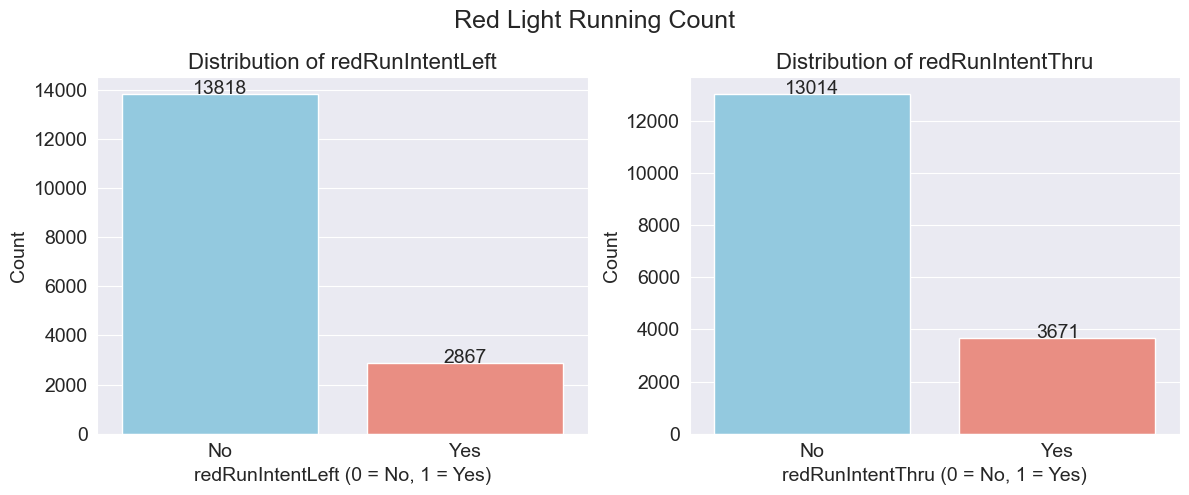

In [18]:
# List of the red light running columns
target_columns = [
    "redRunIntentLeft", "redRunIntentThru", 
    # "redRunUnintentLeft", "redRunUnintentThru"
]

# Creating the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Red Light Running Count", fontsize=18)

# Iterate over each column and create a bar plot
for i, col in enumerate(target_columns):
    ax = axes[i]
    value_counts = df_data[col].value_counts()

    sns.barplot(x=value_counts.index, y=value_counts.values, palette=["skyblue", "salmon"], ax=ax)

    ax.set_xlabel(f"{col} (0 = No, 1 = Yes)", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_title(f"Distribution of {col}", fontsize=16)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["No", "Yes"])

    # Setting font size for ticks
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    
    # Adding count labels on top of each bar
    for index, value in enumerate(value_counts.values):
        ax.text(index, value + 0.1, str(value), ha="center", fontsize=14)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("../report/target_distribution.png", dpi=300)
plt.show()

In [19]:
# df_data.date.dtypes

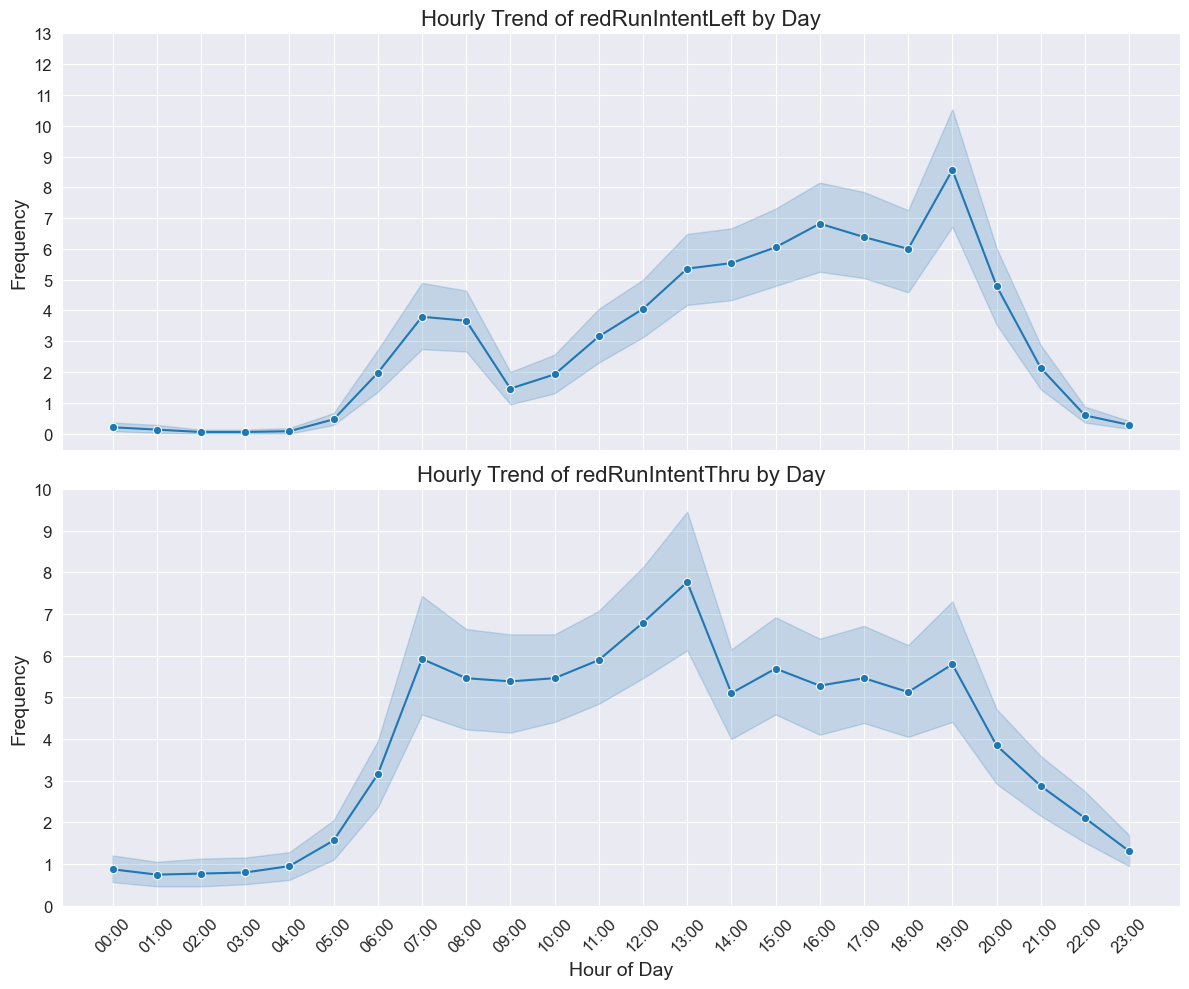

In [20]:
# List of the red light running columns
target_columns = [
    "redRunIntentLeft", "redRunIntentThru", 
    # "redRunUnintentLeft", "redRunUnintentThru"
]

# Resample to hourly and take the max, keeping the result as integers
df_hourly = (
    df_data[target_columns + ["cycleBegin"]]
    .set_index("cycleBegin")
    .resample("H")
    .sum()
    .fillna(0)  # Replace NaN values with 0
    .astype(int)  # Convert to integer type
)

df_hourly["day"] = df_hourly.index.date; df_hourly["hour"] = df_hourly.index.hour

# Plotting hourly trend lines for each feature with day as hue in a 4-row, 1-column layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plotting each feature"s hourly trend line with day as hue
for i, column in enumerate(target_columns):
    sns.lineplot(
        data=df_hourly,
        x="hour",
        y=column,
        ax=axes[i],
        marker="o"
    )
    
    axes[i].set_title(f"Hourly Trend of {column} by Day", fontsize=16)
    axes[i].set_xlabel("Hour of Day", fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    axes[i].set_xticks(range(24))
    axes[i].set_xticklabels([f"{hour:02d}:00" for hour in range(24)], rotation=45, fontsize=12)
    
    # Setting y-ticks as integers and customizing labels
    y_max = int(df_hourly[column].max()) - 5
    axes[i].set_yticks(range(0, y_max))
    axes[i].set_yticklabels([str(tick) for tick in range(0, y_max)], fontsize=12)
    
    axes[i].grid(True)
    # axes[i].legend(title="Day", fontsize=10, loc="upper_right")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("../report/target_trend.png", dpi=300)
plt.show()

## Independent Features

In [21]:
# Create hour", and "day" features
df_data["day"] = df_data["cycleBegin"].dt.day; df_data["hour"] = df_data["cycleBegin"].dt.hour

# Create feature "isWeekday": 1 for weekday (Mon-Fri), 0 for weekend (Sat-Sun)
df_data["isWeekday"] = df_data["cycleBegin"].dt.weekday.apply(lambda x: 0 if x >= 5 else 1)

In [22]:
df_data.head(1)

,signalID,cycleNo,cycleBegin,cycleEnd,cycleLength,greenRatioPhase1,yellowRatioPhase1,redClearanceRatioPhase1,redRatioPhase1,greenRatioPhase2,yellowRatioPhase2,redClearanceRatioPhase2,redRatioPhase2,greenRatioPhase4,yellowRatioPhase4,redClearanceRatioPhase4,redRatioPhase4,greenRatioPhase5,yellowRatioPhase5,redClearanceRatioPhase5,redRatioPhase5,greenRatioPhase6,yellowRatioPhase6,redClearanceRatioPhase6,redRatioPhase6,greenRatioPhase7,yellowRatioPhase7,redClearanceRatioPhase7,redRatioPhase7,greenRatioPhase8,yellowRatioPhase8,redClearanceRatioPhase8,redRatioPhase8,greenRatioPhase3,yellowRatioPhase3,redClearanceRatioPhase3,redRatioPhase3,date,redRunIntentLeft,redRunIntentThru,day,hour,isWeekday
0,1435,2,2024-01-01 00:02:38.300,2024-01-01 00:05:38.400,180.1,0.055,0.0305,0.0111,0.9034,0.3609,0.0305,0.0111,0.5974,0.2499,0.0267,0.0117,0.7118,0.0527,0.0305,0.0111,0.9056,0.3631,0.0305,0.0111,0.5952,0.1388,0.0244,0.0111,0.8257,0.2882,0.0267,0.0117,0.6735,0.1749,0.0267,0.0111,0.7873,2024-01-01,0,0,1,0,1


In [23]:
# Convert ratio to seconds
for i in tqdm.tqdm(range(len(df_data))):
    cycle_length = df_data.at[i, "cycleLength"]

    for column in df_data.columns:
        if "Ratio" in column:
            df_data.at[i, column] = cycle_length * df_data.at[i, column]


# Rename columns that contain 'Ratio' by removing the word 'Ratio'
df_data = df_data.rename(columns=lambda x: x.replace("Ratio", "") if "Ratio" in x else x)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16685/16685 [00:20<00:00, 799.26it/s]


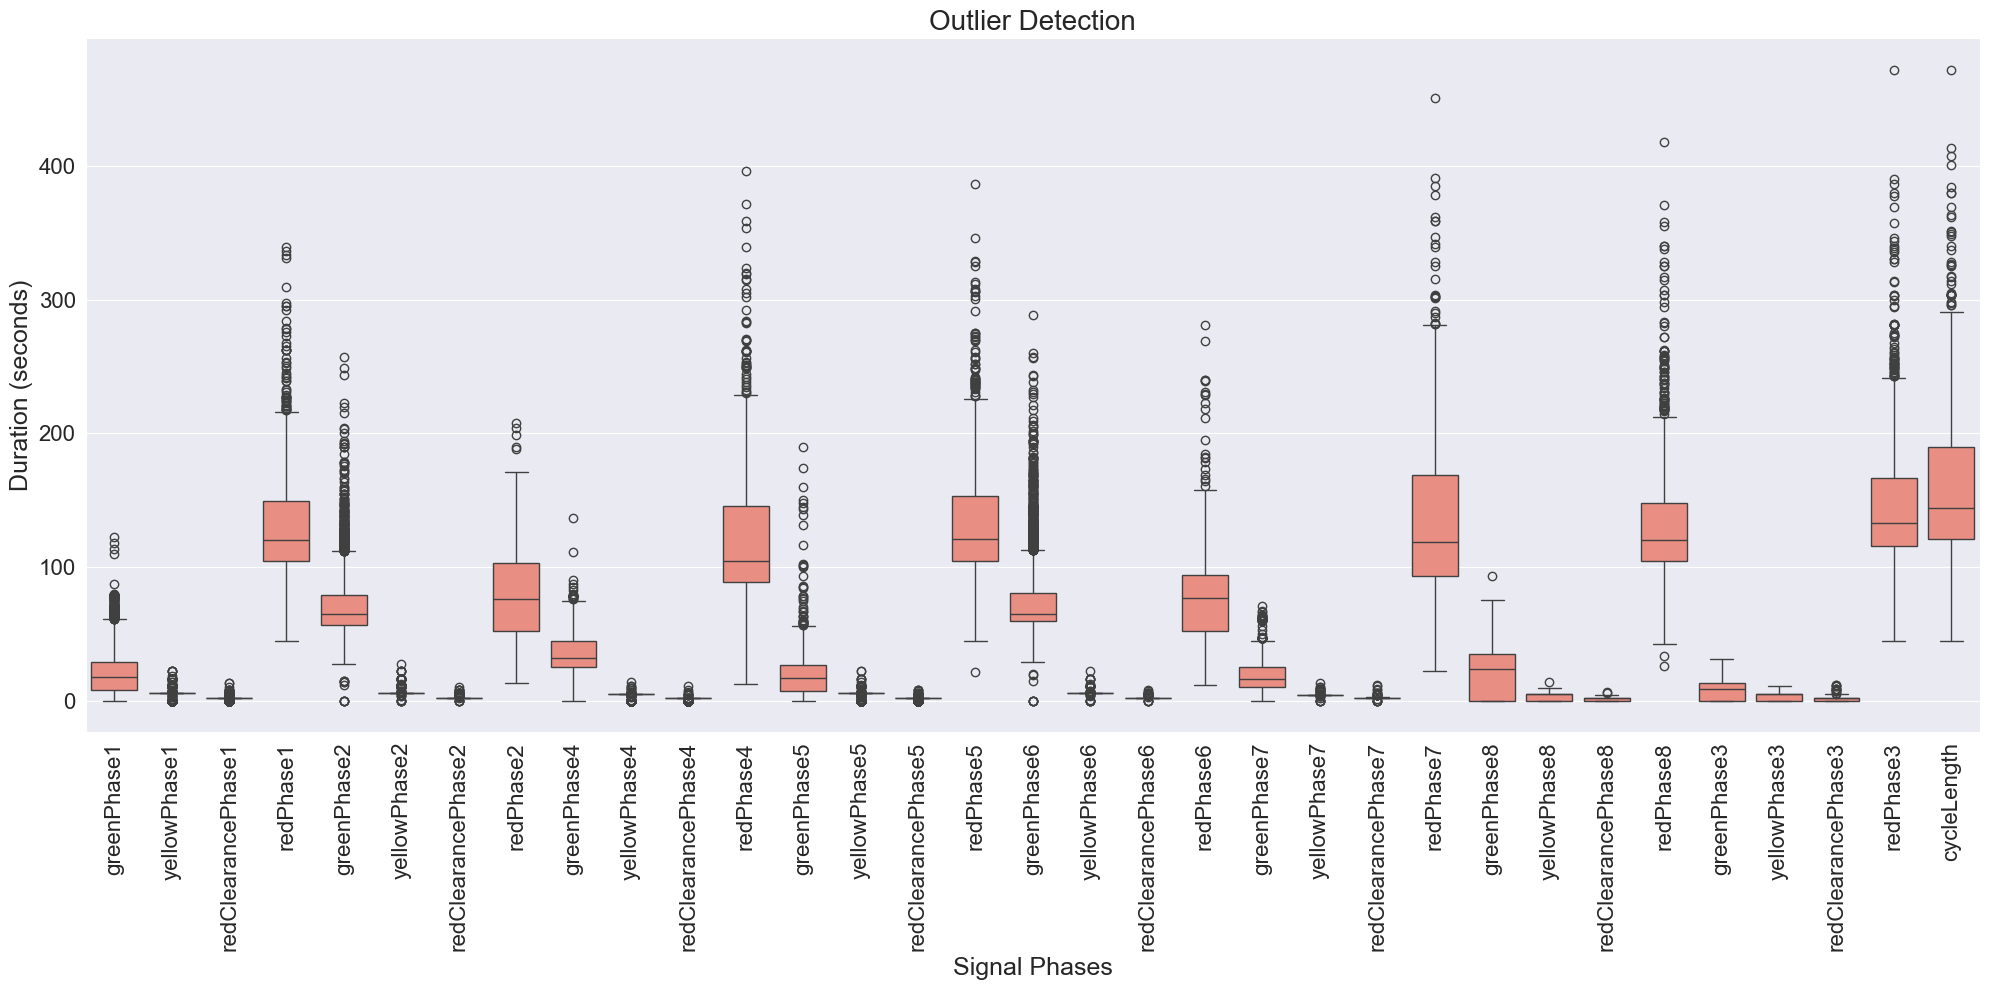

In [24]:
columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# Creating a figure for Seaborn boxplots
plt.figure(figsize=(20, 10))

# Using Seaborn's boxplot function to visualize outliers
sns.boxplot(data=df_data[columns], color="salmon")

plt.title("Outlier Detection", fontsize=20)
plt.xlabel("Signal Phases", fontsize=18)
plt.ylabel("Duration (seconds)", fontsize=18)
plt.xticks(rotation=90)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.tight_layout()
plt.savefig("../report/feature_distribution.png", dpi=300)
plt.show()

In [25]:
# # Applying the IQR method to filter out outliers for each column in the dataset.
# def remove_outliers(df, columns):
#     # Create a copy of the DataFrame to avoid modifying the original data
#     proc_df = df.copy()

#     # Cutoffs
#     cutoffs = []
    
#     # Loop through each column to calculate IQR and filter out outliers
#     for column in columns:
#         # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1

#         # Define lower and upper bounds for outlier detection
#         lower_bound = max(0, Q1 - 1.5 * IQR)  # Adjust lower bound to be at least 0
#         upper_bound = Q3 + 1.5 * IQR

#         # Store the results
#         cutoffs.append({
#             'Feature': column,
#             'Lower Bound': lower_bound,
#             'Upper Bound': upper_bound
#         })

#         # Filter out outliers
#         proc_df = proc_df[(proc_df[column] >= lower_bound) & (proc_df[column] <= upper_bound)]

#     # Create a DataFrame for the cutoffs
#     df_cutoff = pd.DataFrame(cutoffs)

#     return proc_df, df_cutoff

# columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# # Applying the IQR outlier removal method to the dataset
# proc_df_data, df_cutoff = remove_outliers(df=df_data, columns=columns)

In [26]:
# df_cutoff.head()

In [27]:
# columns = [column for column in df_data.columns if "Phase" in column] + ["cycleLength"]

# # Creating a figure for Seaborn boxplots
# plt.figure(figsize=(20, 10))

# # Using Seaborn's boxplot function to visualize outliers
# sns.boxplot(data=proc_df_data[columns], color="salmon")

# plt.title("After Outlier Removal", fontsize=20)
# plt.xlabel("Signal Phases", fontsize=18)
# plt.ylabel("Duration (seconds)", fontsize=18)
# plt.xticks(rotation=90)

# plt.tick_params(axis="x", labelsize=16)
# plt.tick_params(axis="y", labelsize=16)

# plt.tight_layout()

# plt.show()

# Train-Test Split

In [28]:
# Sample dates considering weekend and weekday
dict_dates = {
    "weekend_dates": df_data[df_data["isWeekday"] == 0]["date"].unique().tolist(),
    "weekday_dates": df_data[df_data["isWeekday"] == 1]["date"].unique().tolist(),
}

# Get train and export
train_dates = []
for key in dict_dates.keys():
    random.seed(906)
    train_dates = train_dates + random.sample(dict_dates[key], int(len(dict_dates[key]) * 0.75))

df_train = df_data[df_data.date.isin(train_dates)].reset_index(drop=True)
df_train.to_csv("../data/production/train.csv", index=False)

# Get test and export
df_test = df_data[~df_data.date.isin(train_dates)].reset_index(drop=True)
df_test.to_csv("../data/production/test.csv", index=False)

In [29]:
# Summary of target: Red Light Running
def target_summary(df):
    dict_target = {"featureName": [], "Not Red Run (0)": [], "Red Run (1)": []}
    for column in df.columns:
        if "redRun" in column:
            dict_target["featureName"].append(column)
    
            values = df[column].values.tolist()
            
            dict_target["Not Red Run (0)"].append(values.count(0))
            dict_target["Red Run (1)"].append(values.count(1))

    df_target = pd.DataFrame(dict_target)
    return df_target

In [30]:
print("Distribution of Target in Train Data:")
print(f'{target_summary(df=df_train)}\n')

print('Distribution of Target in Test Data:')
print(target_summary(df=df_test))

Distribution of Target in Train Data:
        featureName  Not Red Run (0)  Red Run (1)
0  redRunIntentLeft            10146         2103
1  redRunIntentThru             9559         2690

Distribution of Target in Test Data:
        featureName  Not Red Run (0)  Red Run (1)
0  redRunIntentLeft             3672          764
1  redRunIntentThru             3455          981
